In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
dest_path ='/liuzicheng/ljh/hyena-dna/data/drosophila_enhancer_activity'
split='test'
targets_file = os.path.join(dest_path, 'Sequences_activity_'+split+".txt")
data = pd.read_csv(targets_file, sep="\t")[
            ["Dev_log2_enrichment", "Hk_log2_enrichment"]
        ]
fasta_file= os.path.join(dest_path, 'Sequences_'+split+".fa")
all_seqs = []
all_labels = []

with open(fasta_file) as fin:
    header = False
    for line in fin:
        l = line.strip()
        if len(l) == 0:  # last line
            break
        if line.startswith(">"):
            header = True
            continue
        else:
            assert header  # check fasta format is correct
            all_seqs.append(l)
        
        
        

all_labels=data[["Dev_log2_enrichment", "Hk_log2_enrichment"]].values.astype("float32").tolist()
        
assert len(all_seqs) == len(
            all_labels
        ), "Number of targets does not match number of sequences"
batch_size=128




restrict = lambda x: (
                    torch.cumsum(x, dim=-2)
                    / torch.arange(
                        1, 1 + x.size(-2), device=x.device, dtype=x.dtype
                    ).unsqueeze(-1)
                )[..., -1:, :]   
from scipy.stats import pearsonr
from scipy import stats
def pearsonr_1(outs, y, len_batch=None):
    # TODO: generalize, currently for Monash dataset
    metrics = {}
    outs=outs.detach()
    for i, label in enumerate(['dev', 'hk']):
        y_true = y[:, i].cpu().numpy()
        p = outs[:, i].cpu().numpy()
        r = stats.pearsonr(y_true, p)[0]
        metrics[f'pearsonr_{label}'] = r
        metrics[f'pearsonr2_{label}'] = r ** 2
    metrics['pearsonr'] = (metrics['pearsonr_dev'] + metrics['pearsonr_hk']) / 2
    return metrics
import torch.nn.functional as F
def mse(outs, y, len_batch=None):
    # assert outs.shape[:-1] == y.shape and outs.shape[-1] == 1
    # outs = outs.squeeze(-1)
    # if len(y.shape) < len(outs.shape):
    #     assert outs.shape[-1] == 1
    #     outs = outs.squeeze(-1)
    if len_batch is None:
        # return F.mse_loss(outs, y)
        loss = (
                            (
                                outs[~torch.isnan(y)]
                                - y[~torch.isnan(y)]
                            )
                            ** 2
                        ).mean()
        #check if y include nan
        if torch.isnan(outs).any():
            nan_indices_outs=torch.nonzero(torch.isnan(outs), as_tuple=False)
            print(nan_indices_outs)
        
        if torch.isnan(y).any():
            nan_indices=torch.nonzero(torch.isnan(y), as_tuple=False)
            print(nan_indices)
        return loss
    else:
        # Computes the loss of the first `lens` items in the batches
        # TODO document the use case of this
        mask = torch.zeros_like(outs, dtype=torch.bool)
        for i, l in enumerate(len_batch):
            mask[i, :l, :] = 1
        outs_masked = torch.masked_select(outs, mask)
        y_masked = torch.masked_select(y, mask)
        return F.mse_loss(outs_masked, y_masked)

In [2]:
from transformers import AutoTokenizer,AutoModel
import torch
from torch import nn

max_length=128

with torch.no_grad():
    state_dict='/liuzicheng/ljh/hyena-dna/weight/hyenadna/hyenadna-large-1m-seqlen'
    hyena_tokenizer=AutoTokenizer.from_pretrained(state_dict, trust_remote_code=True)
    hyena_model=AutoModel.from_pretrained(state_dict, trust_remote_code=True).to('cuda')
    full_sequence=[]
    checkpoint=torch.load('/liuzicheng/ljh/hyena-dna/outputs/2024-05-04/13-01-30-043019/checkpoints/val/pearsonr.ckpt')['state_dict']
    torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "model.backbone."
        )
    torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "decoder.0.output_transform."
        )

    hyena_decoder = nn.Linear(256,2).to('cuda')
    #edit key name in hyena_decoder
    
    hyena_model.load_state_dict(checkpoint,strict=False)
    hyena_decoder.load_state_dict(checkpoint,strict=False)
    hyena_model.eval()
    hyena_decoder.eval()

    seqs=[]
    targets=[]
    for i in range(batch_size):
        sequence_encoded=hyena_tokenizer(all_seqs[i],
                            add_special_tokens= False,  # this is what controls adding eos
                            padding="max_length",
                            max_length=max_length,
                            truncation=True,
                        )
        seq_ids=sequence_encoded['input_ids']
        seq_ids = torch.LongTensor(seq_ids)
        target = torch.FloatTensor(all_labels[i])
        seqs.append(seq_ids)
        targets.append(target) 

    seqs=torch.stack(seqs).to('cuda')
    targets=torch.stack(targets).to('cuda')

    
    hidden_states=hyena_model(input_ids=seqs).last_hidden_state
    hidden_states=restrict(hidden_states)
    out1=hyena_decoder(hidden_states)
    out1_hyena=out1.squeeze(1)

    #calculate the 
    pearsonr=pearsonr_1(out1_hyena,targets)
    print(pearsonr)
    mse_loss=mse(out1_hyena,targets)
    print(mse_loss)

#plot the bar plot of the pearsonr


/liuzicheng/anaconda3/envs/evo-design/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'pearsonr_dev': 0.30961149658885806, 'pearsonr2_dev': 0.09585927881999247, 'pearsonr_hk': 0.6928641595330266, 'pearsonr2_hk': 0.48006074356540734, 'pearsonr': 0.5012378280609423}
tensor(3.7100, device='cuda:0')


<BarContainer object of 128 artists>

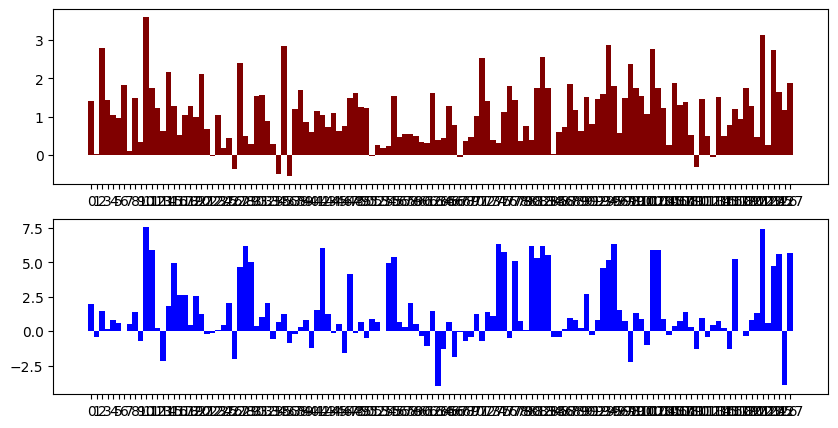

In [3]:
import matplotlib.pyplot as plt
import numpy as np

out_pearsonr_dev=out1_hyena.cpu().numpy()[:,0]
out_pearsonr_hk=out1_hyena.cpu().numpy()[:,1]
target_pearsonr_dev=targets.cpu().numpy()[:,0]
target_pearsonr_hk=targets.cpu().numpy()[:,1]

courses=[]
for i in range(batch_size):
    courses.append(str(i))
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,5))
ax1.bar(courses, out_pearsonr_dev, color ='maroon', 
        width = 1)
ax2.bar(courses, target_pearsonr_hk, color = 'blue',
        width = 1)

In [4]:
from transformers import AutoTokenizer,AutoModel
import torch
from torch import nn

max_length=128
def group_by_kmer(seq: str, kmer: int) -> str:
        return " ".join(seq[i : i + kmer] for i in range(0, len(seq), kmer)).upper()
with torch.no_grad():
    state_dict='/liuzicheng/ljh/hyena-dna/weight/dnabert/dnabert3/3-new-12w-0'
    bert_tokenizer=AutoTokenizer.from_pretrained(state_dict, trust_remote_code=True)
    bert_model=AutoModel.from_pretrained(state_dict, trust_remote_code=True).to('cuda')
    full_sequence=[]
    checkpoint=torch.load('/liuzicheng/ljh/hyena-dna/outputs/2024-03-29/04-45-15-121292/checkpoints/val/pearsonr.ckpt')['state_dict']
    torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "model.backbone."
        )
    torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "decoder.0.output_transform."
        )

    bert_decoder = nn.Linear(768,2).to('cuda')
    #edit key name in hyena_decoder
    
    bert_model.load_state_dict(checkpoint,strict=False)
    bert_decoder.load_state_dict(checkpoint,strict=False)
    bert_model.eval()
    bert_decoder.eval()

    seqs=[]
    targets=[]
    for i in range(batch_size):
        all_seqs_group = group_by_kmer(all_seqs[i],kmer=3)
        sequence_encoded=bert_tokenizer(all_seqs_group,
                            add_special_tokens= False,  # this is what controls adding eos
                            padding="max_length",
                            max_length=max_length,
                            truncation=True,
                        )
        seq_ids=sequence_encoded['input_ids']
        seq_ids = torch.LongTensor(seq_ids)
        target = torch.FloatTensor(all_labels[i])
        seqs.append(seq_ids)
        targets.append(target) 

    seqs=torch.stack(seqs).to('cuda')
    targets=torch.stack(targets).to('cuda')

    
    hidden_states=bert_model(input_ids=seqs).last_hidden_state
    hidden_states=restrict(hidden_states)
    out1=bert_decoder(hidden_states)
    out1_bert=out1.squeeze(1)

    #calculate the 
    pearsonr=pearsonr_1(out1_bert,targets)
    print(pearsonr)
    mse_loss=mse(out1_bert,targets)
    print(mse_loss)

#plot the bar plot of the pearsonr


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (0) is identical to the `bos_token_id` (0), `eos_token_id` (None), or the `sep_token_id` (None), and your input is not padded.


{'pearsonr_dev': 0.42143904180104075, 'pearsonr2_dev': 0.17761086595417938, 'pearsonr_hk': 0.8681981144647186, 'pearsonr2_hk': 0.7537679659600927, 'pearsonr': 0.6448185781328797}
tensor(2.1491, device='cuda:0')


In [5]:
from transformers import AutoTokenizer,AutoModel
import torch
from torch import nn

max_length=128
def group_by_kmer(seq: str, kmer: int) -> str:
        return " ".join(seq[i : i + kmer] for i in range(0, len(seq), kmer)).upper()
with torch.no_grad():
    state_dict='/liuzicheng/ljh/hyena-dna/weight/dnabert2'
    bert2_tokenizer=AutoTokenizer.from_pretrained(state_dict, trust_remote_code=True)
    bert2_model=AutoModel.from_pretrained(state_dict, trust_remote_code=True).to('cuda')
    full_sequence=[]
    checkpoint=torch.load('/liuzicheng/ljh/hyena-dna/outputs/2024-03-29/08-13-54-405523/checkpoints/val/pearsonr.ckpt')['state_dict']
    torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "model.backbone."
        )
    torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "decoder.0.output_transform."
        )

    bert2_decoder = nn.Linear(768,2).to('cuda')
    #edit key name in hyena_decoder
    
    bert2_model.load_state_dict(checkpoint,strict=False)
    bert2_decoder.load_state_dict(checkpoint,strict=False)
    bert2_model.eval()
    bert2_decoder.eval()

    seqs=[]
    targets=[]
    for i in range(batch_size):
        # all_seqs[i] = group_by_kmer(all_seqs[i],kmer=3)
        sequence_encoded=bert2_tokenizer(all_seqs[i],
                            add_special_tokens= False,  # this is what controls adding eos
                            padding="max_length",
                            max_length=max_length,
                            truncation=True,
                        )
        seq_ids=sequence_encoded['input_ids']
        seq_ids = torch.LongTensor(seq_ids)
        target = torch.FloatTensor(all_labels[i])
        seqs.append(seq_ids)
        targets.append(target) 

    seqs=torch.stack(seqs).to('cuda')
    targets=torch.stack(targets).to('cuda')

    
    hidden_states=bert2_model(input_ids=seqs,export_hidden_states=True)[0]
    hidden_states=restrict(hidden_states)
    out1=bert2_decoder(hidden_states)
    out1_bert2=out1.squeeze(1)

    #calculate the 
    pearsonr=pearsonr_1(out1_bert2,targets)
    print(pearsonr)
    mse_loss=mse(out1_bert2,targets)
    print(mse_loss)

#plot the bar plot of the pearsonr


/root/.cache/huggingface/modules/transformers_modules/dnabert2/bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at /liuzicheng/ljh/hyena-dna/weight/dnabert2 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'pearsonr_dev': 0.4540241693812713, 'pearsonr2_dev': 0.20613794638235336, 'pearsonr_hk': 0.8943409549581318, 'pearsonr2_hk': 0.7998457437154232, 'pearsonr': 0.6741825621697015}
tensor(1.8355, device='cuda:0')


In [6]:
from transformers import AutoTokenizer,AutoModel,AutoModelForMaskedLM
import torch
from torch import nn

max_length=128
def group_by_kmer(seq: str, kmer: int) -> str:
        return " ".join(seq[i : i + kmer] for i in range(0, len(seq), kmer)).upper()
with torch.no_grad():
    state_dict='/liuzicheng/ljh/hyena-dna/weight/nt/nucleotide-transformer-v2-500m-multi-species'
    nt_tokenizer=AutoTokenizer.from_pretrained(state_dict, trust_remote_code=True)
    nt_model=AutoModelForMaskedLM.from_pretrained(state_dict, trust_remote_code=True).to('cuda')
    full_sequence=[]
    checkpoint=torch.load('/liuzicheng/ljh/hyena-dna/outputs/2024-03-29/10-42-51-953352/checkpoints/val/pearsonr.ckpt')['state_dict']
    torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "model.backbone."
        )
    torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "decoder.0.output_transform."
        )

    nt_decoder = nn.Linear(1024,2).to('cuda')
    #edit key name in hyena_decoder
    
    nt_model.load_state_dict(checkpoint,strict=False)
    nt_decoder.load_state_dict(checkpoint,strict=False)
    nt_model.eval()
    nt_decoder.eval()

    seqs=[]
    targets=[]
    for i in range(batch_size):
        # all_seqs[i] = group_by_kmer(all_seqs[i],kmer=3)
        sequence_encoded=nt_tokenizer(all_seqs[i],
                            add_special_tokens= False,  # this is what controls adding eos
                            padding="max_length",
                            max_length=max_length,
                            truncation=True,
                        )
        seq_ids=sequence_encoded['input_ids']
        seq_ids = torch.LongTensor(seq_ids)
        target = torch.FloatTensor(all_labels[i])
        seqs.append(seq_ids)
        targets.append(target) 

    seqs=torch.stack(seqs).to('cuda')
    targets=torch.stack(targets).to('cuda')

    
    hidden_states=nt_model(input_ids=seqs,output_hidden_states=True)['hidden_states'][-1]
    hidden_states=restrict(hidden_states)
    out1=nt_decoder(hidden_states)
    out1_nt=out1.squeeze(1)

    #calculate the 
    pearsonr=pearsonr_1(out1_nt,targets)
    print(pearsonr)
    mse_loss=mse(out1_nt,targets)
    print(mse_loss)

#plot the bar plot of the pearsonr


{'pearsonr_dev': 0.4694219483154807, 'pearsonr2_dev': 0.22035696556030182, 'pearsonr_hk': 0.9022603591393571, 'pearsonr2_hk': 0.8140737556742816, 'pearsonr': 0.6858411537274189}
tensor(4.9831, device='cuda:0')


In [7]:
from transformers import AutoTokenizer,AutoModel,AutoModelForMaskedLM
import torch
from torch import nn

max_length=128
def group_by_kmer(seq: str, kmer: int) -> str:
        return " ".join(seq[i : i + kmer] for i in range(0, len(seq), kmer)).upper()
with torch.no_grad():
    state_dict='/liuzicheng/ljh/hyena-dna/weight/genalm/gena-lm-bert-large-t2t'
    genalm_tokenizer=AutoTokenizer.from_pretrained(state_dict, trust_remote_code=True)
    genalm_model=AutoModel.from_pretrained(state_dict, trust_remote_code=True).to('cuda')
    full_sequence=[]
    checkpoint=torch.load('/liuzicheng/ljh/hyena-dna/outputs/2024-03-30/01-49-47-161996/checkpoints/val/pearsonr.ckpt')['state_dict']
    torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "model.backbone."
        )
    torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "decoder.0.output_transform."
        )

    genalm_decoder = nn.Linear(1024,2).to('cuda')
    #edit key name in hyena_decoder
    
    genalm_model.load_state_dict(checkpoint,strict=False)
    genalm_decoder.load_state_dict(checkpoint,strict=False)
    genalm_model.eval()
    genalm_decoder.eval()

    seqs=[]
    targets=[]
    for i in range(batch_size):
        # all_seqs[i] = group_by_kmer(all_seqs[i],kmer=3)
        sequence_encoded=genalm_tokenizer(all_seqs[i],
                            add_special_tokens= False,  # this is what controls adding eos
                            padding="max_length",
                            max_length=max_length,
                            truncation=True,
                        )
        seq_ids=sequence_encoded['input_ids']
        seq_ids = torch.LongTensor(seq_ids)
        target = torch.FloatTensor(all_labels[i])
        seqs.append(seq_ids)
        targets.append(target) 

    seqs=torch.stack(seqs).to('cuda')
    targets=torch.stack(targets).to('cuda')

    
    hidden_states=genalm_model(input_ids=seqs, output_hidden_states=True,).hidden_states[-1]
    hidden_states=restrict(hidden_states)
    out1=genalm_decoder(hidden_states)
    out1_genalm=out1.squeeze(1)

    #calculate the 
    pearsonr=pearsonr_1(out1_genalm,targets)
    print(pearsonr)
    mse_loss=mse(out1_genalm,targets)
    print(mse_loss)

#plot the bar plot of the pearsonr


/liuzicheng/anaconda3/envs/evo-design/lib/python3.11/site-packages/transformers/modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'pearsonr_dev': 0.4184000191584494, 'pearsonr2_dev': 0.1750585760317908, 'pearsonr_hk': 0.877784393314563, 'pearsonr2_hk': 0.7705054411466155, 'pearsonr': 0.6480922062365062}
tensor(2.5849, device='cuda:0')


In [8]:


from transformers import AutoTokenizer,AutoModel,AutoModelForMaskedLM
import torch
from torch import nn

max_length=128
def group_by_kmer(seq: str, kmer: int) -> str:
        return " ".join(seq[i : i + kmer] for i in range(0, len(seq), kmer)).upper()
with torch.no_grad():
    state_dict='/liuzicheng/ljh/hyena-dna/weight/mamba/caduceus-ph_seqlen-131k_d_model-256_n_layer-16'
    mamba_tokenizer=AutoTokenizer.from_pretrained(state_dict, trust_remote_code=True)
    mamba_model=AutoModel.from_pretrained(state_dict, trust_remote_code=True).to('cuda')
    full_sequence=[]
    checkpoint=torch.load('/liuzicheng/ljh/hyena-dna/outputs/2024-04-19/14-39-48-177210/checkpoints/val/pearsonr.ckpt')['state_dict']
    torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "model.backbone."
        )
    torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "decoder.0.output_transform."
        )

    mamba_decoder = nn.Linear(256,2).to('cuda')
    #edit key name in hyena_decoder
    
    mamba_model.load_state_dict(checkpoint,strict=False)
    mamba_decoder.load_state_dict(checkpoint,strict=False)
    mamba_model.eval()
    mamba_decoder.eval()

    seqs=[]
    targets=[]
    for i in range(batch_size):
        # all_seqs[i] = group_by_kmer(all_seqs[i],kmer=3)
        sequence_encoded=mamba_tokenizer(all_seqs[i],
                            add_special_tokens= False,  # this is what controls adding eos
                            padding="max_length",
                            max_length=max_length,
                            truncation=True,
                        )
        seq_ids=sequence_encoded['input_ids']
        seq_ids = torch.LongTensor(seq_ids)
        target = torch.FloatTensor(all_labels[i])
        seqs.append(seq_ids)
        targets.append(target) 

    seqs=torch.stack(seqs).to('cuda')
    targets=torch.stack(targets).to('cuda')

    
    hidden_states=mamba_model(seqs,output_hidden_states=True).last_hidden_state
    hidden_states=restrict(hidden_states)
    out1=mamba_decoder(hidden_states)
    out1_mamba=out1.squeeze(1)

    #calculate the 
    pearsonr=pearsonr_1(out1_mamba,targets)
    print(pearsonr)
    mse_loss=mse(out1_mamba,targets)
    print(mse_loss)

#plot the bar plot of the pearsonr


{'pearsonr_dev': 0.2754864175244956, 'pearsonr2_dev': 0.07589276624048072, 'pearsonr_hk': 0.6713994220847209, 'pearsonr2_hk': 0.4507771839756972, 'pearsonr': 0.4734429198046083}
tensor(4.7213, device='cuda:0')


In [9]:


from transformers import AutoTokenizer,AutoModel,AutoModelForMaskedLM
import torch
from torch import nn

max_length=128
import sys
sys.path.append('/liuzicheng/ljh/hyena-dna/')
from src.models.sequence.deepSTAR import DeepSTAR
def genomic_to_one_hot(genomic_sequence):
        mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
        one_hot = np.zeros((len(genomic_sequence), 4))
        for i, base in enumerate(genomic_sequence):
            if base in mapping:
                one_hot[i, mapping[base]] = 1
            else:
                # 如果碱基不是A、C、G、T或N，可以选择将其编码为全零向量或者平均分配概率
                one_hot[i, :] = 0.25  # 或者使用 np.full((5,), 0.2) 平均分配概率
        return one_hot
with torch.no_grad():
    DeepSTAR_model=DeepSTAR(input_size=128,output_size=2)
    full_sequence=[]
    checkpoint=torch.load('/liuzicheng/ljh/hyena-dna/outputs/2024-05-13/09-21-43-779050/checkpoints/val/pearsonr.ckpt')['state_dict']
    torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "model.backbone."
        )
    

    #edit key name in hyena_decoder
    
    DeepSTAR_model.load_state_dict(checkpoint,strict=False)
    DeepSTAR_model.to('cuda')
    DeepSTAR_model.eval()

    seqs=[]
    targets=[]
    for i in range(batch_size):
        # all_seqs[i] = group_by_kmer(all_seqs[i],kmer=3)
        seq=genomic_to_one_hot(all_seqs[i])
        seq_ids = torch.from_numpy(seq).float()[:max_length,:]
        target = torch.FloatTensor(all_labels[i])
        seqs.append(seq_ids)
        targets.append(target) 

    seqs=torch.stack(seqs).to('cuda')
    targets=torch.stack(targets).to('cuda')

    
    hidden_states=DeepSTAR_model(seqs)
    out1_deepstar=hidden_states.squeeze(1).squeeze(0)

    #calculate the 
    pearsonr=pearsonr_1(out1_deepstar,targets)
    print(pearsonr)
    mse_loss=mse(out1_deepstar,targets)
    print(mse_loss)

#plot the bar plot of the pearsonr


{'pearsonr_dev': 0.24356750966933174, 'pearsonr2_dev': 0.05932513176652001, 'pearsonr_hk': 0.6165632380395126, 'pearsonr2_hk': 0.3801502265017687, 'pearsonr': 0.4300653738544222}
tensor(4.4993, device='cuda:0')


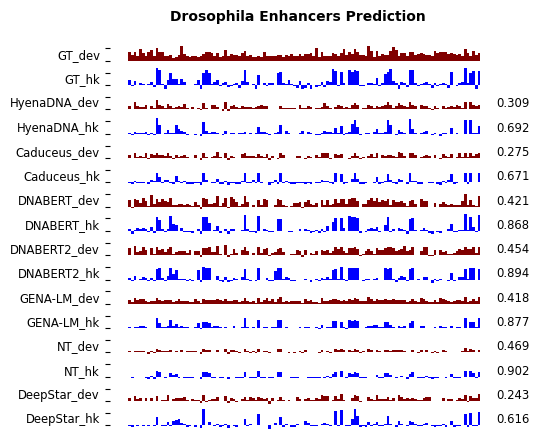

In [10]:
import matplotlib.pyplot as plt
import numpy as np

out_hyena_pearsonr_dev=out1_hyena.cpu().numpy()[:,0]
out_hyena_pearsonr_hk=out1_hyena.cpu().numpy()[:,1]
target_pearsonr_dev=targets.cpu().numpy()[:,0]
target_pearsonr_hk=targets.cpu().numpy()[:,1]
out_mamba_pearsonr_dev=out1_mamba.cpu().numpy()[:,0]
out_mamba_pearsonr_hk=out1_mamba.cpu().numpy()[:,1]
out_bert_pearsonr_dev=out1_bert.cpu().numpy()[:,0]
out_bert_pearsonr_hk=out1_bert.cpu().numpy()[:,1]
out_bert2_pearsonr_dev=out1_bert2.cpu().numpy()[:,0]
out_bert2_pearsonr_hk=out1_bert2.cpu().numpy()[:,1]
out_genalm_pearsonr_dev=out1_genalm.cpu().numpy()[:,0]
out_genalm_pearsonr_hk=out1_genalm.cpu().numpy()[:,1]
out_nt_pearsonr_dev=out1_nt.cpu().numpy()[:,0]
out_nt_pearsonr_hk=out1_nt.cpu().numpy()[:,1]
out_deepstar_pearsonr_dev=out1_deepstar.cpu().numpy()[:,0]
out_deepstar_pearsonr_hk=out1_deepstar.cpu().numpy()[:,1]

max=np.max([np.max(out_hyena_pearsonr_dev),np.max(out_hyena_pearsonr_hk),np.max(out_mamba_pearsonr_dev),np.max(out_mamba_pearsonr_hk),np.max(out_bert_pearsonr_dev),np.max(out_bert_pearsonr_hk),np.max(out_bert2_pearsonr_dev),np.max(out_bert2_pearsonr_hk),np.max(out_genalm_pearsonr_dev),np.max(out_genalm_pearsonr_hk),np.max(out_nt_pearsonr_dev),np.max(out_nt_pearsonr_hk),np.max(out_deepstar_pearsonr_dev),np.max(out_deepstar_pearsonr_hk)])
min=np.min([np.min(out_hyena_pearsonr_dev),np.min(out_hyena_pearsonr_hk),np.min(out_mamba_pearsonr_dev),np.min(out_mamba_pearsonr_hk),np.min(out_bert_pearsonr_dev),np.min(out_bert_pearsonr_hk),np.min(out_bert2_pearsonr_dev),np.min(out_bert2_pearsonr_hk),np.min(out_genalm_pearsonr_dev),np.min(out_genalm_pearsonr_hk),np.min(out_nt_pearsonr_dev),np.min(out_nt_pearsonr_hk),np.min(out_deepstar_pearsonr_dev),np.min(out_deepstar_pearsonr_hk)])

courses=[]
for i in range(batch_size):
    courses.append(i*0.1)
fig,(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16)=plt.subplots(16,1,figsize=(5,5),sharex=True)
ax1.bar(courses, target_pearsonr_dev, color ='maroon',  align='edge',
        width = 0.1)
ax1.set_ylim(min,max)
#remove x-axis label
ax1.set_xticklabels([])
#remove y-axis label
ax1.set_yticklabels([])

#remove x-axis ticks
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#remove y-axis ticks
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
#remove boundary
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

ax1_twin = ax1.twinx()
ax1_twin.set_xticklabels([])
ax1_twin.set_yticklabels([])
ax1_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax1_twin.spines['top'].set_visible(False)
ax1_twin.spines['right'].set_visible(False)
ax1_twin.spines['bottom'].set_visible(False)
ax1_twin.spines['left'].set_visible(False)

ax2.bar(courses, target_pearsonr_hk, color = 'blue', align='edge',
        width = 0.1)
ax2.set_ylim(min,max)
ax2.set_xticklabels([])
#remove y-axis label
ax2.set_yticklabels([])

#remove x-axis ticks
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#remove y-axis ticks
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
#remove boundary
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax2_twin = ax2.twinx()
ax2_twin.set_xticklabels([])
ax2_twin.set_yticklabels([])
ax2_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax2_twin.spines['top'].set_visible(False)
ax2_twin.spines['right'].set_visible(False)
ax2_twin.spines['bottom'].set_visible(False)
ax2_twin.spines['left'].set_visible(False)

ax3.bar(courses, out_hyena_pearsonr_dev, color = 'maroon', align='edge',
        width = 0.1)
ax3.set_ylim(min,max)
ax3.set_xticklabels([])
#remove y-axis label
ax3.set_yticklabels([])

#remove x-axis ticks
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#remove y-axis ticks
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
#remove boundary
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3_twin = ax3.twinx()
ax3_twin.set_xticklabels([])
ax3_twin.set_yticklabels([])
ax3_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax3_twin.spines['top'].set_visible(False)
ax3_twin.spines['right'].set_visible(False)
ax3_twin.spines['bottom'].set_visible(False)
ax3_twin.spines['left'].set_visible(False)


ax4.bar(courses, out_hyena_pearsonr_hk, color = 'blue', align='edge',
        width = 0.1)
ax4.set_ylim(min,max)
ax4.set_xticklabels([])
#remove y-axis label
ax4.set_yticklabels([])


#remove x-axis ticks
ax4.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax4.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax4.spines['top'].set_visible(False)        
ax4.spines['right'].set_visible(False)        
ax4.spines['bottom'].set_visible(False)        
ax4.spines['left'].set_visible(False)     

ax4_twin = ax4.twinx()
ax4_twin.set_xticklabels([])
ax4_twin.set_yticklabels([])
ax4_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax4_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax4_twin.spines['top'].set_visible(False)
ax4_twin.spines['right'].set_visible(False)
ax4_twin.spines['bottom'].set_visible(False)
ax4_twin.spines['left'].set_visible(False)

ax5.bar(courses, out_mamba_pearsonr_dev, color = 'maroon', align='edge',
        width = 0.1)
ax5.set_ylim(min,max)
ax5.set_xticklabels([])
#remove y-axis label
ax5.set_yticklabels([])


#remove x-axis ticks
ax5.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax5.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax5.spines['top'].set_visible(False)        
ax5.spines['right'].set_visible(False)        
ax5.spines['bottom'].set_visible(False)        
ax5.spines['left'].set_visible(False)        


ax5_twin = ax5.twinx()
ax5_twin.set_xticklabels([])
ax5_twin.set_yticklabels([])    

ax5_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax5_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax5_twin.spines['top'].set_visible(False)
ax5_twin.spines['right'].set_visible(False)
ax5_twin.spines['bottom'].set_visible(False)
ax5_twin.spines['left'].set_visible(False)


ax6.bar(courses, out_mamba_pearsonr_hk, color = 'blue', align='edge',
        width = 0.1)
ax6.set_ylim(min,max)
ax6.set_xticklabels([])
#remove y-axis label
ax6.set_yticklabels([])


#remove x-axis ticks
ax6.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax6.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax6.spines['top'].set_visible(False)        
ax6.spines['right'].set_visible(False)        
ax6.spines['bottom'].set_visible(False)        
ax6.spines['left'].set_visible(False)   

ax6_twin = ax6.twinx()
ax6_twin.set_xticklabels([])
ax6_twin.set_yticklabels([])
ax6_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax6_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax6_twin.spines['top'].set_visible(False)
ax6_twin.spines['right'].set_visible(False)
ax6_twin.spines['bottom'].set_visible(False)
ax6_twin.spines['left'].set_visible(False)


ax7.bar(courses, out_bert_pearsonr_dev, color = 'maroon', align='edge',
        width = 0.1)
ax7.set_ylim(min,max)
ax7.set_xticklabels([])
#remove y-axis label
ax7.set_yticklabels([])


#remove x-axis ticks
ax7.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax7.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax7.spines['top'].set_visible(False)        
ax7.spines['right'].set_visible(False)        
ax7.spines['bottom'].set_visible(False)        
ax7.spines['left'].set_visible(False)        

ax7_twin = ax7.twinx()
ax7_twin.set_xticklabels([])
ax7_twin.set_yticklabels([])
ax7_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax7_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax7_twin.spines['top'].set_visible(False)
ax7_twin.spines['right'].set_visible(False)
ax7_twin.spines['bottom'].set_visible(False)
ax7_twin.spines['left'].set_visible(False)

ax8.bar(courses, out_bert_pearsonr_hk, color = 'blue', align='edge',
        width = 0.1)
ax8.set_ylim(min,max)
ax8.set_xticklabels([])
#remove y-axis label
ax8.set_yticklabels([])


#remove x-axis ticks
ax8.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax8.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax8.spines['top'].set_visible(False)        
ax8.spines['right'].set_visible(False)        
ax8.spines['bottom'].set_visible(False)        
ax8.spines['left'].set_visible(False)        

ax8_twin = ax8.twinx()
ax8_twin.set_xticklabels([])
ax8_twin.set_yticklabels([])
ax8_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax8_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax8_twin.spines['top'].set_visible(False)
ax8_twin.spines['right'].set_visible(False)
ax8_twin.spines['bottom'].set_visible(False)
ax8_twin.spines['left'].set_visible(False)

ax9.bar(courses, out_bert2_pearsonr_dev, color = 'maroon', align='edge',
        width = 0.1)
ax9.set_ylim(min,max)
ax9.set_xticklabels([])
#remove y-axis label
ax9.set_yticklabels([])


#remove x-axis ticks
ax9.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax9.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax9.spines['top'].set_visible(False)        
ax9.spines['right'].set_visible(False)        
ax9.spines['bottom'].set_visible(False)        
ax9.spines['left'].set_visible(False)        

ax9_twin = ax9.twinx()
ax9_twin.set_xticklabels([])
ax9_twin.set_yticklabels([])
ax9_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax9_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax9_twin.spines['top'].set_visible(False)
ax9_twin.spines['right'].set_visible(False)
ax9_twin.spines['bottom'].set_visible(False)
ax9_twin.spines['left'].set_visible(False)

ax10.bar(courses, out_bert2_pearsonr_hk, color = 'blue', align='edge',
        width = 0.1)
ax10.set_ylim(min,max)
ax10.set_xticklabels([])
#remove y-axis label
ax10.set_yticklabels([])


#remove x-axis ticks
ax10.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax10.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax10.spines['top'].set_visible(False)        
ax10.spines['right'].set_visible(False)        
ax10.spines['bottom'].set_visible(False)        
ax10.spines['left'].set_visible(False)    

ax10_twin = ax10.twinx()
ax10_twin.set_xticklabels([])
ax10_twin.set_yticklabels([])
ax10_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax10_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax10_twin.spines['top'].set_visible(False)
ax10_twin.spines['right'].set_visible(False)
ax10_twin.spines['bottom'].set_visible(False)
ax10_twin.spines['left'].set_visible(False)


ax11.bar(courses, out_genalm_pearsonr_dev, color = 'maroon', align='edge',
        width = 0.1)
ax11.set_ylim(min,max)
ax11.set_xticklabels([])
#remove y-axis label
ax11.set_yticklabels([])


#remove x-axis ticks
ax11.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks                
ax11.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax11.spines['top'].set_visible(False)        
ax11.spines['right'].set_visible(False)        
ax11.spines['bottom'].set_visible(False)        
ax11.spines['left'].set_visible(False)  

ax11_twin = ax11.twinx()
ax11_twin.set_xticklabels([])
ax11_twin.set_yticklabels([])
ax11_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax11_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax11_twin.spines['top'].set_visible(False)
ax11_twin.spines['right'].set_visible(False)
ax11_twin.spines['bottom'].set_visible(False)
ax11_twin.spines['left'].set_visible(False)


ax12.bar(courses, out_genalm_pearsonr_hk, color = 'blue', align='edge',
        width = 0.1)
ax12.set_ylim(min,max)
ax12.set_xticklabels([])
#remove y-axis label
ax12.set_yticklabels([])


#remove x-axis ticks
ax12.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax12.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax12.spines['top'].set_visible(False)        
ax12.spines['right'].set_visible(False)        
ax12.spines['bottom'].set_visible(False)        
ax12.spines['left'].set_visible(False)        

ax12_twin = ax12.twinx()
ax12_twin.set_xticklabels([])
ax12_twin.set_yticklabels([])
ax12_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax12_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax12_twin.spines['top'].set_visible(False)
ax12_twin.spines['right'].set_visible(False)
ax12_twin.spines['bottom'].set_visible(False)
ax12_twin.spines['left'].set_visible(False)


ax13.bar(courses, out_nt_pearsonr_dev, color = 'maroon', align='edge',
        width = 0.1)
ax13.set_ylim(min,max)
ax13.set_xticklabels([])
#remove y-axis label
ax13.set_yticklabels([])


#remove x-axis ticks
ax13.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax13.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax13.spines['top'].set_visible(False)        
ax13.spines['right'].set_visible(False)        
ax13.spines['bottom'].set_visible(False)        
ax13.spines['left'].set_visible(False)        

ax13_twin = ax13.twinx()
ax13_twin.set_xticklabels([])
ax13_twin.set_yticklabels([])
ax13_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax13_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 

ax13_twin.spines['top'].set_visible(False)
ax13_twin.spines['right'].set_visible(False)
ax13_twin.spines['bottom'].set_visible(False)
ax13_twin.spines['left'].set_visible(False)

ax14.bar(courses, out_nt_pearsonr_hk, color = 'blue', align='edge',
        width = 0.1)
ax14.set_ylim(min,max)
ax14.set_xticklabels([])
#remove y-axis label
ax14.set_yticklabels([])


#remove x-axis ticks
ax14.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax14.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax14.spines['top'].set_visible(False)        
ax14.spines['right'].set_visible(False)        
ax14.spines['bottom'].set_visible(False)        
ax14.spines['left'].set_visible(False)      

ax14_twin = ax14.twinx()
ax14_twin.set_xticklabels([])
ax14_twin.set_yticklabels([])
ax14_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax14_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax14_twin.spines['top'].set_visible(False)
ax14_twin.spines['right'].set_visible(False)
ax14_twin.spines['bottom'].set_visible(False)
ax14_twin.spines['left'].set_visible(False)

ax15.bar(courses, out_deepstar_pearsonr_dev, color = 'maroon', align='edge',
         
        width = 0.1)
ax15.set_ylim(min,max)
ax15.set_xticklabels([])
#remove y-axis label
ax15.set_yticklabels([])


#remove x-axis ticks
ax15.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax15.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax15.spines['top'].set_visible(False)        
ax15.spines['right'].set_visible(False)        
ax15.spines['bottom'].set_visible(False)        
ax15.spines['left'].set_visible(False)        


ax15_twin = ax15.twinx()
ax15_twin.set_xticklabels([])
ax15_twin.set_yticklabels([])
ax15_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax15_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax15_twin.spines['top'].set_visible(False)
ax15_twin.spines['right'].set_visible(False)
ax15_twin.spines['bottom'].set_visible(False)
ax15_twin.spines['left'].set_visible(False)

ax16.bar(courses, out_deepstar_pearsonr_hk, color = 'blue', align='edge',
        width = 0.1)
ax16.set_ylim(min,max)
ax16.set_xticklabels([])
#remove y-axis label
ax16.set_yticklabels([])


#remove x-axis ticks
ax16.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax16.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax16.spines['top'].set_visible(False)        
ax16.spines['right'].set_visible(False)        
ax16.spines['bottom'].set_visible(False)        
ax16.spines['left'].set_visible(False)        

ax16_twin = ax16.twinx()
ax16_twin.set_xticklabels([])
ax16_twin.set_yticklabels([])
ax16_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax16_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax16_twin.spines['top'].set_visible(False)
ax16_twin.spines['right'].set_visible(False)
ax16_twin.spines['bottom'].set_visible(False)
ax16_twin.spines['left'].set_visible(False)


ax1.yaxis.set_label_position('left')
ax1.set_ylabel('GT_dev', rotation=0, size='small',
                   ha='right', va='center')
ax2.yaxis.set_label_position('left')
ax2.set_ylabel('GT_hk', rotation=0, size='small',
                   ha='right', va='center')
ax3.yaxis.set_label_position('left')
ax3.set_ylabel('HyenaDNA_dev', rotation=0, size='small',
                   ha='right', va='center')
ax3_twin.yaxis.set_label_position('right')
ax3_twin.set_ylabel('0.309', rotation=0, size='small',
                    
                   ha='center', va='center')
#add y-axis label from both left and right side

ax4.yaxis.set_label_position('left')
ax4.set_ylabel('HyenaDNA_hk', rotation=0, size='small',
                   ha='right', va='center')
ax4_twin.yaxis.set_label_position('right')
ax4_twin.set_ylabel('0.692', rotation=0, size='small',
                    
                   ha='center', va='center')

ax5.yaxis.set_label_position('left')
ax5.set_ylabel('Caduceus_dev', rotation=0, size='small',
                   ha='right', va='center')
ax5_twin.yaxis.set_label_position('right')
ax5_twin.set_ylabel('0.275', rotation=0, size='small',
                    
                   ha='center', va='center')

ax6.yaxis.set_label_position('left')
ax6.set_ylabel('Caduceus_hk', rotation=0, size='small',
                   ha='right', va='center')
ax6_twin.yaxis.set_label_position('right')
ax6_twin.set_ylabel('0.671', rotation=0, size='small',
                    
                   ha='center', va='center')

ax7.yaxis.set_label_position('left')
ax7.set_ylabel('DNABERT_dev', rotation=0, size='small',
                   ha='right', va='center')
ax7_twin.yaxis.set_label_position('right')
ax7_twin.set_ylabel('0.421', rotation=0, size='small',
                    
                   ha='center', va='center')
ax8.yaxis.set_label_position('left')
ax8.set_ylabel('DNABERT_hk', rotation=0, size='small',
                   ha='right', va='center')
ax8_twin.yaxis.set_label_position('right')
ax8_twin.set_ylabel('0.868', rotation=0, size='small',
                    
                   ha='center', va='center')

ax9.yaxis.set_label_position('left')
ax9.set_ylabel('DNABERT2_dev', rotation=0, size='small',
                   ha='right', va='center')
ax9_twin.yaxis.set_label_position('right')
ax9_twin.set_ylabel('0.454', rotation=0, size='small',
                    
                   ha='center', va='center')
ax10.yaxis.set_label_position('left')
ax10.set_ylabel('DNABERT2_hk', rotation=0, size='small',
                   ha='right', va='center')
ax10_twin.yaxis.set_label_position('right')
ax10_twin.set_ylabel('0.894', rotation=0, size='small',
                     
                    
                   ha='center', va='center')
ax11.yaxis.set_label_position('left')
ax11.set_ylabel('GENA-LM_dev', rotation=0, size='small',
                   ha='right', va='center')
ax11_twin.yaxis.set_label_position('right')
ax11_twin.set_ylabel('0.418', rotation=0, size='small',
                     ha='center', va='center')

ax12.yaxis.set_label_position('left')
ax12.set_ylabel('GENA-LM_hk', rotation=0, size='small',
                   ha='right', va='center')
ax12_twin.yaxis.set_label_position('right')
ax12_twin.set_ylabel('0.877', rotation=0, size='small',
                     ha='center', va='center')
ax13.yaxis.set_label_position('left')
ax13.set_ylabel('NT_dev', rotation=0, size='small',
                   ha='right', va='center')
ax13_twin.yaxis.set_label_position('right')
ax13_twin.set_ylabel('0.469', rotation=0, size='small',
                     ha='center', va='center')
ax14.yaxis.set_label_position('left')
ax14.set_ylabel('NT_hk', rotation=0, size='small',
                   ha='right', va='center')
ax14_twin.yaxis.set_label_position('right')
ax14_twin.set_ylabel('0.902', rotation=0, size='small',
                     ha='center', va='center')
ax15.yaxis.set_label_position('left')
ax15.set_ylabel('DeepStar_dev', rotation=0, size='small',
                   ha='right', va='center')
ax15_twin.yaxis.set_label_position('right')
ax15_twin.set_ylabel('0.243', rotation=0, size='small',
                     ha='center', va='center')
ax16.yaxis.set_label_position('left')
ax16.set_ylabel('DeepStar_hk', rotation=0, size='small',
                   ha='right', va='center')
ax16_twin.yaxis.set_label_position('right')
ax16_twin.set_ylabel('0.616', rotation=0, size='small',
                     ha='center', va='center')
plt.suptitle('Drosophila Enhancers Prediction',fontsize=10,y=0.95,fontweight='bold')

#save as pdf
plt.savefig('Drosophila_Enhancers_Prediction.pdf',bbox_inches='tight')

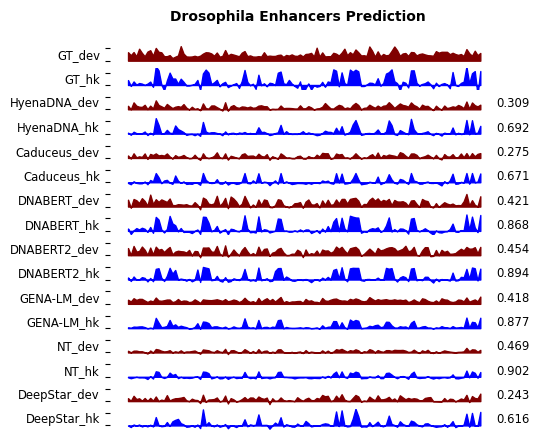

In [11]:
import matplotlib.pyplot as plt
import numpy as np

out_hyena_pearsonr_dev=out1_hyena.cpu().numpy()[:,0]
out_hyena_pearsonr_hk=out1_hyena.cpu().numpy()[:,1]
target_pearsonr_dev=targets.cpu().numpy()[:,0]
target_pearsonr_hk=targets.cpu().numpy()[:,1]
out_mamba_pearsonr_dev=out1_mamba.cpu().numpy()[:,0]
out_mamba_pearsonr_hk=out1_mamba.cpu().numpy()[:,1]
out_bert_pearsonr_dev=out1_bert.cpu().numpy()[:,0]
out_bert_pearsonr_hk=out1_bert.cpu().numpy()[:,1]
out_bert2_pearsonr_dev=out1_bert2.cpu().numpy()[:,0]
out_bert2_pearsonr_hk=out1_bert2.cpu().numpy()[:,1]
out_genalm_pearsonr_dev=out1_genalm.cpu().numpy()[:,0]
out_genalm_pearsonr_hk=out1_genalm.cpu().numpy()[:,1]
out_nt_pearsonr_dev=out1_nt.cpu().numpy()[:,0]
out_nt_pearsonr_hk=out1_nt.cpu().numpy()[:,1]
out_deepstar_pearsonr_dev=out1_deepstar.cpu().numpy()[:,0]
out_deepstar_pearsonr_hk=out1_deepstar.cpu().numpy()[:,1]

max=np.max([np.max(out_hyena_pearsonr_dev),np.max(out_hyena_pearsonr_hk),np.max(out_mamba_pearsonr_dev),np.max(out_mamba_pearsonr_hk),np.max(out_bert_pearsonr_dev),np.max(out_bert_pearsonr_hk),np.max(out_bert2_pearsonr_dev),np.max(out_bert2_pearsonr_hk),np.max(out_genalm_pearsonr_dev),np.max(out_genalm_pearsonr_hk),np.max(out_nt_pearsonr_dev),np.max(out_nt_pearsonr_hk),np.max(out_deepstar_pearsonr_dev),np.max(out_deepstar_pearsonr_hk)])
min=np.min([np.min(out_hyena_pearsonr_dev),np.min(out_hyena_pearsonr_hk),np.min(out_mamba_pearsonr_dev),np.min(out_mamba_pearsonr_hk),np.min(out_bert_pearsonr_dev),np.min(out_bert_pearsonr_hk),np.min(out_bert2_pearsonr_dev),np.min(out_bert2_pearsonr_hk),np.min(out_genalm_pearsonr_dev),np.min(out_genalm_pearsonr_hk),np.min(out_nt_pearsonr_dev),np.min(out_nt_pearsonr_hk),np.min(out_deepstar_pearsonr_dev),np.min(out_deepstar_pearsonr_hk)])

courses=[]
for i in range(batch_size):
    courses.append(i*0.1)
fig,(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16)=plt.subplots(16,1,figsize=(5,5),sharex=True)
ax1.fill_between(courses, target_pearsonr_dev, color ='maroon')
ax1.set_ylim(min,max)
#remove x-axis label
ax1.set_xticklabels([])
#remove y-axis label
ax1.set_yticklabels([])

#remove x-axis ticks
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#remove y-axis ticks
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
#remove boundary
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

ax1_twin = ax1.twinx()
ax1_twin.set_xticklabels([])
ax1_twin.set_yticklabels([])
ax1_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax1_twin.spines['top'].set_visible(False)
ax1_twin.spines['right'].set_visible(False)
ax1_twin.spines['bottom'].set_visible(False)
ax1_twin.spines['left'].set_visible(False)

ax2.fill_between(courses, target_pearsonr_hk, color = 'blue')
ax2.set_ylim(min,max)
ax2.set_xticklabels([])
#remove y-axis label
ax2.set_yticklabels([])

#remove x-axis ticks
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#remove y-axis ticks
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
#remove boundary
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax2_twin = ax2.twinx()
ax2_twin.set_xticklabels([])
ax2_twin.set_yticklabels([])
ax2_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax2_twin.spines['top'].set_visible(False)
ax2_twin.spines['right'].set_visible(False)
ax2_twin.spines['bottom'].set_visible(False)
ax2_twin.spines['left'].set_visible(False)

ax3.fill_between(courses, out_hyena_pearsonr_dev, color = 'maroon')
ax3.set_ylim(min,max)
ax3.set_xticklabels([])
#remove y-axis label
ax3.set_yticklabels([])

#remove x-axis ticks
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#remove y-axis ticks
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
#remove boundary
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3_twin = ax3.twinx()
ax3_twin.set_xticklabels([])
ax3_twin.set_yticklabels([])
ax3_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax3_twin.spines['top'].set_visible(False)
ax3_twin.spines['right'].set_visible(False)
ax3_twin.spines['bottom'].set_visible(False)
ax3_twin.spines['left'].set_visible(False)


ax4.fill_between(courses, out_hyena_pearsonr_hk, color = 'blue')
ax4.set_ylim(min,max)
ax4.set_xticklabels([])
#remove y-axis label
ax4.set_yticklabels([])


#remove x-axis ticks
ax4.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax4.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax4.spines['top'].set_visible(False)        
ax4.spines['right'].set_visible(False)        
ax4.spines['bottom'].set_visible(False)        
ax4.spines['left'].set_visible(False)     

ax4_twin = ax4.twinx()
ax4_twin.set_xticklabels([])
ax4_twin.set_yticklabels([])
ax4_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax4_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax4_twin.spines['top'].set_visible(False)
ax4_twin.spines['right'].set_visible(False)
ax4_twin.spines['bottom'].set_visible(False)
ax4_twin.spines['left'].set_visible(False)

ax5.fill_between(courses, out_mamba_pearsonr_dev, color = 'maroon')
ax5.set_ylim(min,max)
ax5.set_xticklabels([])
#remove y-axis label
ax5.set_yticklabels([])


#remove x-axis ticks
ax5.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax5.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax5.spines['top'].set_visible(False)        
ax5.spines['right'].set_visible(False)        
ax5.spines['bottom'].set_visible(False)        
ax5.spines['left'].set_visible(False)        


ax5_twin = ax5.twinx()
ax5_twin.set_xticklabels([])
ax5_twin.set_yticklabels([])    

ax5_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax5_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax5_twin.spines['top'].set_visible(False)
ax5_twin.spines['right'].set_visible(False)
ax5_twin.spines['bottom'].set_visible(False)
ax5_twin.spines['left'].set_visible(False)


ax6.fill_between(courses, out_mamba_pearsonr_hk, color = 'blue')
ax6.set_ylim(min,max)
ax6.set_xticklabels([])
#remove y-axis label
ax6.set_yticklabels([])


#remove x-axis ticks
ax6.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax6.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax6.spines['top'].set_visible(False)        
ax6.spines['right'].set_visible(False)        
ax6.spines['bottom'].set_visible(False)        
ax6.spines['left'].set_visible(False)   

ax6_twin = ax6.twinx()
ax6_twin.set_xticklabels([])
ax6_twin.set_yticklabels([])
ax6_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax6_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax6_twin.spines['top'].set_visible(False)
ax6_twin.spines['right'].set_visible(False)
ax6_twin.spines['bottom'].set_visible(False)
ax6_twin.spines['left'].set_visible(False)


ax7.fill_between(courses, out_bert_pearsonr_dev, color = 'maroon')
ax7.set_ylim(min,max)
ax7.set_xticklabels([])
#remove y-axis label
ax7.set_yticklabels([])


#remove x-axis ticks
ax7.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax7.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax7.spines['top'].set_visible(False)        
ax7.spines['right'].set_visible(False)        
ax7.spines['bottom'].set_visible(False)        
ax7.spines['left'].set_visible(False)        

ax7_twin = ax7.twinx()
ax7_twin.set_xticklabels([])
ax7_twin.set_yticklabels([])
ax7_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax7_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax7_twin.spines['top'].set_visible(False)
ax7_twin.spines['right'].set_visible(False)
ax7_twin.spines['bottom'].set_visible(False)
ax7_twin.spines['left'].set_visible(False)

ax8.fill_between(courses, out_bert_pearsonr_hk, color = 'blue')
ax8.set_ylim(min,max)
ax8.set_xticklabels([])
#remove y-axis label
ax8.set_yticklabels([])


#remove x-axis ticks
ax8.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax8.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax8.spines['top'].set_visible(False)        
ax8.spines['right'].set_visible(False)        
ax8.spines['bottom'].set_visible(False)        
ax8.spines['left'].set_visible(False)        

ax8_twin = ax8.twinx()
ax8_twin.set_xticklabels([])
ax8_twin.set_yticklabels([])
ax8_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax8_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax8_twin.spines['top'].set_visible(False)
ax8_twin.spines['right'].set_visible(False)
ax8_twin.spines['bottom'].set_visible(False)
ax8_twin.spines['left'].set_visible(False)

ax9.fill_between(courses, out_bert2_pearsonr_dev, color = 'maroon')
ax9.set_ylim(min,max)
ax9.set_xticklabels([])
#remove y-axis label
ax9.set_yticklabels([])


#remove x-axis ticks
ax9.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax9.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax9.spines['top'].set_visible(False)        
ax9.spines['right'].set_visible(False)        
ax9.spines['bottom'].set_visible(False)        
ax9.spines['left'].set_visible(False)        

ax9_twin = ax9.twinx()
ax9_twin.set_xticklabels([])
ax9_twin.set_yticklabels([])
ax9_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax9_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax9_twin.spines['top'].set_visible(False)
ax9_twin.spines['right'].set_visible(False)
ax9_twin.spines['bottom'].set_visible(False)
ax9_twin.spines['left'].set_visible(False)

ax10.fill_between(courses, out_bert2_pearsonr_hk, color = 'blue')
ax10.set_ylim(min,max)
ax10.set_xticklabels([])
#remove y-axis label
ax10.set_yticklabels([])


#remove x-axis ticks
ax10.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax10.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax10.spines['top'].set_visible(False)        
ax10.spines['right'].set_visible(False)        
ax10.spines['bottom'].set_visible(False)        
ax10.spines['left'].set_visible(False)    

ax10_twin = ax10.twinx()
ax10_twin.set_xticklabels([])
ax10_twin.set_yticklabels([])
ax10_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax10_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax10_twin.spines['top'].set_visible(False)
ax10_twin.spines['right'].set_visible(False)
ax10_twin.spines['bottom'].set_visible(False)
ax10_twin.spines['left'].set_visible(False)


ax11.fill_between(courses, out_genalm_pearsonr_dev, color = 'maroon')
ax11.set_ylim(min,max)
ax11.set_xticklabels([])
#remove y-axis label
ax11.set_yticklabels([])


#remove x-axis ticks
ax11.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks                
ax11.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax11.spines['top'].set_visible(False)        
ax11.spines['right'].set_visible(False)        
ax11.spines['bottom'].set_visible(False)        
ax11.spines['left'].set_visible(False)  

ax11_twin = ax11.twinx()
ax11_twin.set_xticklabels([])
ax11_twin.set_yticklabels([])
ax11_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax11_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax11_twin.spines['top'].set_visible(False)
ax11_twin.spines['right'].set_visible(False)
ax11_twin.spines['bottom'].set_visible(False)
ax11_twin.spines['left'].set_visible(False)


ax12.fill_between(courses, out_genalm_pearsonr_hk, color = 'blue')
ax12.set_ylim(min,max)
ax12.set_xticklabels([])
#remove y-axis label
ax12.set_yticklabels([])


#remove x-axis ticks
ax12.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax12.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax12.spines['top'].set_visible(False)        
ax12.spines['right'].set_visible(False)        
ax12.spines['bottom'].set_visible(False)        
ax12.spines['left'].set_visible(False)        

ax12_twin = ax12.twinx()
ax12_twin.set_xticklabels([])
ax12_twin.set_yticklabels([])
ax12_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax12_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax12_twin.spines['top'].set_visible(False)
ax12_twin.spines['right'].set_visible(False)
ax12_twin.spines['bottom'].set_visible(False)
ax12_twin.spines['left'].set_visible(False)


ax13.fill_between(courses, out_nt_pearsonr_dev, color = 'maroon')
ax13.set_ylim(min,max)
ax13.set_xticklabels([])
#remove y-axis label
ax13.set_yticklabels([])


#remove x-axis ticks
ax13.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax13.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax13.spines['top'].set_visible(False)        
ax13.spines['right'].set_visible(False)        
ax13.spines['bottom'].set_visible(False)        
ax13.spines['left'].set_visible(False)        

ax13_twin = ax13.twinx()
ax13_twin.set_xticklabels([])
ax13_twin.set_yticklabels([])
ax13_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax13_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 

ax13_twin.spines['top'].set_visible(False)
ax13_twin.spines['right'].set_visible(False)
ax13_twin.spines['bottom'].set_visible(False)
ax13_twin.spines['left'].set_visible(False)

ax14.fill_between(courses, out_nt_pearsonr_hk, color = 'blue')
ax14.set_ylim(min,max)
ax14.set_xticklabels([])
#remove y-axis label
ax14.set_yticklabels([])


#remove x-axis ticks
ax14.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax14.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax14.spines['top'].set_visible(False)        
ax14.spines['right'].set_visible(False)        
ax14.spines['bottom'].set_visible(False)        
ax14.spines['left'].set_visible(False)      

ax14_twin = ax14.twinx()
ax14_twin.set_xticklabels([])
ax14_twin.set_yticklabels([])
ax14_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax14_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax14_twin.spines['top'].set_visible(False)
ax14_twin.spines['right'].set_visible(False)
ax14_twin.spines['bottom'].set_visible(False)
ax14_twin.spines['left'].set_visible(False)

ax15.fill_between(courses, out_deepstar_pearsonr_dev, color = 'maroon')
ax15.set_ylim(min,max)
ax15.set_xticklabels([])
#remove y-axis label
ax15.set_yticklabels([])


#remove x-axis ticks
ax15.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax15.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax15.spines['top'].set_visible(False)        
ax15.spines['right'].set_visible(False)        
ax15.spines['bottom'].set_visible(False)        
ax15.spines['left'].set_visible(False)        


ax15_twin = ax15.twinx()
ax15_twin.set_xticklabels([])
ax15_twin.set_yticklabels([])
ax15_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax15_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax15_twin.spines['top'].set_visible(False)
ax15_twin.spines['right'].set_visible(False)
ax15_twin.spines['bottom'].set_visible(False)
ax15_twin.spines['left'].set_visible(False)

ax16.fill_between(courses, out_deepstar_pearsonr_hk, color = 'blue')
ax16.set_ylim(min,max)
ax16.set_xticklabels([])
#remove y-axis label
ax16.set_yticklabels([])


#remove x-axis ticks
ax16.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax16.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax16.spines['top'].set_visible(False)        
ax16.spines['right'].set_visible(False)        
ax16.spines['bottom'].set_visible(False)        
ax16.spines['left'].set_visible(False)        

ax16_twin = ax16.twinx()
ax16_twin.set_xticklabels([])
ax16_twin.set_yticklabels([])
ax16_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax16_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax16_twin.spines['top'].set_visible(False)
ax16_twin.spines['right'].set_visible(False)
ax16_twin.spines['bottom'].set_visible(False)
ax16_twin.spines['left'].set_visible(False)


ax1.yaxis.set_label_position('left')
ax1.set_ylabel('GT_dev', rotation=0, size='small',
                   ha='right', va='center')
ax2.yaxis.set_label_position('left')
ax2.set_ylabel('GT_hk', rotation=0, size='small',
                   ha='right', va='center')
ax3.yaxis.set_label_position('left')
ax3.set_ylabel('HyenaDNA_dev', rotation=0, size='small',
                   ha='right', va='center')
ax3_twin.yaxis.set_label_position('right')
ax3_twin.set_ylabel('0.309', rotation=0, size='small',
                    
                   ha='center', va='center')
#add y-axis label from both left and right side

ax4.yaxis.set_label_position('left')
ax4.set_ylabel('HyenaDNA_hk', rotation=0, size='small',
                   ha='right', va='center')
ax4_twin.yaxis.set_label_position('right')
ax4_twin.set_ylabel('0.692', rotation=0, size='small',
                    
                   ha='center', va='center')

ax5.yaxis.set_label_position('left')
ax5.set_ylabel('Caduceus_dev', rotation=0, size='small',
                   ha='right', va='center')
ax5_twin.yaxis.set_label_position('right')
ax5_twin.set_ylabel('0.275', rotation=0, size='small',
                    
                   ha='center', va='center')

ax6.yaxis.set_label_position('left')
ax6.set_ylabel('Caduceus_hk', rotation=0, size='small',
                   ha='right', va='center')
ax6_twin.yaxis.set_label_position('right')
ax6_twin.set_ylabel('0.671', rotation=0, size='small',
                    
                   ha='center', va='center')

ax7.yaxis.set_label_position('left')
ax7.set_ylabel('DNABERT_dev', rotation=0, size='small',
                   ha='right', va='center')
ax7_twin.yaxis.set_label_position('right')
ax7_twin.set_ylabel('0.421', rotation=0, size='small',
                    
                   ha='center', va='center')
ax8.yaxis.set_label_position('left')
ax8.set_ylabel('DNABERT_hk', rotation=0, size='small',
                   ha='right', va='center')
ax8_twin.yaxis.set_label_position('right')
ax8_twin.set_ylabel('0.868', rotation=0, size='small',
                    
                   ha='center', va='center')

ax9.yaxis.set_label_position('left')
ax9.set_ylabel('DNABERT2_dev', rotation=0, size='small',
                   ha='right', va='center')
ax9_twin.yaxis.set_label_position('right')
ax9_twin.set_ylabel('0.454', rotation=0, size='small',
                    
                   ha='center', va='center')
ax10.yaxis.set_label_position('left')
ax10.set_ylabel('DNABERT2_hk', rotation=0, size='small',
                   ha='right', va='center')
ax10_twin.yaxis.set_label_position('right')
ax10_twin.set_ylabel('0.894', rotation=0, size='small',
                     
                    
                   ha='center', va='center')
ax11.yaxis.set_label_position('left')
ax11.set_ylabel('GENA-LM_dev', rotation=0, size='small',
                   ha='right', va='center')
ax11_twin.yaxis.set_label_position('right')
ax11_twin.set_ylabel('0.418', rotation=0, size='small',
                     ha='center', va='center')

ax12.yaxis.set_label_position('left')
ax12.set_ylabel('GENA-LM_hk', rotation=0, size='small',
                   ha='right', va='center')
ax12_twin.yaxis.set_label_position('right')
ax12_twin.set_ylabel('0.877', rotation=0, size='small',
                     ha='center', va='center')
ax13.yaxis.set_label_position('left')
ax13.set_ylabel('NT_dev', rotation=0, size='small',
                   ha='right', va='center')
ax13_twin.yaxis.set_label_position('right')
ax13_twin.set_ylabel('0.469', rotation=0, size='small',
                     ha='center', va='center')
ax14.yaxis.set_label_position('left')
ax14.set_ylabel('NT_hk', rotation=0, size='small',
                   ha='right', va='center')
ax14_twin.yaxis.set_label_position('right')
ax14_twin.set_ylabel('0.902', rotation=0, size='small',
                     ha='center', va='center')
ax15.yaxis.set_label_position('left')
ax15.set_ylabel('DeepStar_dev', rotation=0, size='small',
                   ha='right', va='center')
ax15_twin.yaxis.set_label_position('right')
ax15_twin.set_ylabel('0.243', rotation=0, size='small',
                     ha='center', va='center')
ax16.yaxis.set_label_position('left')
ax16.set_ylabel('DeepStar_hk', rotation=0, size='small',
                   ha='right', va='center')
ax16_twin.yaxis.set_label_position('right')
ax16_twin.set_ylabel('0.616', rotation=0, size='small',
                     ha='center', va='center')
plt.suptitle('Drosophila Enhancers Prediction',fontsize=10,y=0.95,fontweight='bold')

#save as pdf
plt.savefig('Drosophila_Enhancers_Prediction.pdf',bbox_inches='tight')
plt.savefig('Drosophila_Enhancers_Prediction.png',bbox_inches='tight')